<a href="https://colab.research.google.com/github/francesco-source/DeepLearning/blob/main/image_inpainting/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Gan on cifar 10

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, metrics
from tensorflow.keras.optimizers import Adam
from keras import callbacks
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import plot_model

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print("image range is {}, {}".format(np.min(x_test,axis=(0,1,2,3)),np.max(x_test,axis=(0,1,2,3))))
x_train = (x_train/255.).astype(np.float32)
x_test = (x_test/255.).astype(np.float32)
print("new image range is {}, {}".format(np.min(x_test,axis=(0,1,2,3)),np.max(x_test,axis=(0,1,2,3))))

170498071/170498071 [==============================] - 4s 0us/step
image range is 0, 255
new image range is 0.0, 1.0


In [3]:
class ResidualConvolutionBlock(tf.keras.layers.Layer):
    def __init__(self, channels):
      super(ResidualConvolutionBlock, self).__init__()
      self.conv1 = tf.keras.layers.Conv2D(channels, (3, 3), padding='same', activation='relu')
      self.conv2 = tf.keras.layers.Conv2D(channels, (3, 3), padding='same', activation='relu')

    def call(self, inputs):
      conv1 = self.conv1(inputs)
      conv2 = self.conv2(conv1)
      output = conv2 + inputs
      return output

class ResidualConvolutionBlockBottleneck(tf.keras.layers.Layer):
    def __init__(self, channels):
      super(ResidualConvolutionBlockBottleneck, self).__init__()
      self.conv1 = tf.keras.layers.Conv2D(channels, (3, 3), padding='same')
      self.conv2 = tf.keras.layers.Conv2D(channels, (3, 3), padding='same')
      self.bottleneck = tf.keras.layers.Conv2D(channels, (1, 1), padding='same')
      self.dropout = tf.keras.layers.Dropout(0.5)

    def call(self, inputs):
      conv1 = self.conv1(inputs)
      conv1 = tf.keras.layers.LeakyReLU()(conv1)

      conv2 = self.conv2(conv1)
      conv2 = tf.keras.layers.LeakyReLU()(conv2)

      output = conv2 + self.bottleneck(inputs)
      output = self.dropout(output)

      return output


class SecondModel(tf.keras.Model):
  def __init__(self):
    super(SecondModel, self).__init__()
    self.conv1 = tf.keras.layers.Conv2D(32, (3, 3), padding='same')
    self.rcbs1 = [ResidualConvolutionBlock(32), ResidualConvolutionBlock(32), ResidualConvolutionBlock(32), ResidualConvolutionBlock(32)]

    self.downsampling1 = tf.keras.layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same')
    self.rcbs2 = [ResidualConvolutionBlock(64), ResidualConvolutionBlock(64), ResidualConvolutionBlock(64), ResidualConvolutionBlock(64)]

    self.downsampling2 = tf.keras.layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same')
    self.rcbs3 = [ResidualConvolutionBlock(128), ResidualConvolutionBlock(128), ResidualConvolutionBlock(128), ResidualConvolutionBlock(128)]

    self.downsampling3 = tf.keras.layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same')
    self.rcbs4 = [ResidualConvolutionBlock(256), ResidualConvolutionBlock(256), ResidualConvolutionBlock(256), ResidualConvolutionBlock(256)]

    self.upsampling1 = tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')
    self.upconv1 = tf.keras.layers.Conv2D(128, (3, 3), padding='same')
    self.leakyrelu1 = tf.keras.layers.LeakyReLU()
    self.rcbb1 = ResidualConvolutionBlockBottleneck(128)

    self.upsampling2 = tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')
    self.upconv2 = tf.keras.layers.Conv2D(64, (3, 3), padding='same')
    self.leakyrelu2 = tf.keras.layers.LeakyReLU()
    self.rcbb2 = ResidualConvolutionBlockBottleneck(64)

    self.upsampling3 = tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')
    self.upconv3 = tf.keras.layers.Conv2D(32, (3, 3), padding='same')
    self.leakyrelu3 = tf.keras.layers.LeakyReLU()
    self.rcbb3 = ResidualConvolutionBlockBottleneck(32)

    self.last_conv = tf.keras.layers.Conv2D(3, (3, 3), padding='same')
  
  def call(self, inputs):
    output1 = self.conv1(inputs)

    for block in self.rcbs1:
      output1 = block(output1)

    output2 = self.downsampling1(output1)

    for block in self.rcbs2:
      output2 = block(output2)

    output3 = self.downsampling2(output2)

    for block in self.rcbs3:
      output3 = block(output3)

    output4 = self.downsampling3(output3)

    for block in self.rcbs4:
      output4 = block(output4)

    output5 = self.upsampling1(output4)
    output5 = self.upconv1(output5)
    output5 = self.leakyrelu1(output5)

    output5 = tf.keras.layers.concatenate([output3, output5])
    output5 = self.rcbb1(output5)

    output5 = self.upsampling2(output5)
    output5 = self.upconv2(output5)
    output5 = self.leakyrelu2(output5)

    output5 = tf.keras.layers.concatenate([output2, output5])
    output5 = self.rcbb2(output5)
    
    output5 = self.upsampling3(output5)
    output5 = self.upconv3(output5)
    output5 = self.leakyrelu3(output5)

    output5 = tf.keras.layers.concatenate([output1, output5])
    output5 = self.rcbb3(output5)

    output5 = self.last_conv(output5)
    output5 = tf.keras.layers.add([inputs, output5])
  
    return output5
    

In [4]:
def mask(X,coords):
  x0,y0,x1,y1 = coords
  X[:,x0:x1,y0:y1] = 0
  return X


masked_x_train = mask(np.copy(x_train),(2,16,30,30))
masked_x_test = mask(np.copy(x_test),(2,16,30,30))

In [5]:
def display_history(history):
    mse_training = history.history['loss']

    mse_val = history.history['val_loss']

    # Visualize the behavior of the loss
    plt.plot(mse_training)
    plt.plot(mse_val)
    plt.grid()
    plt.title('Loss during training/validation')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'])
    plt.show()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 target_image (InputLayer)      [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 32, 32, 6)    0           ['input_image[0][0]',            
                                                                  'target_image[0][0]']           
                                                                                                  
 sequential (Sequential)        (None, 16, 16, 64)   6144        ['concatenate[0][0]']        

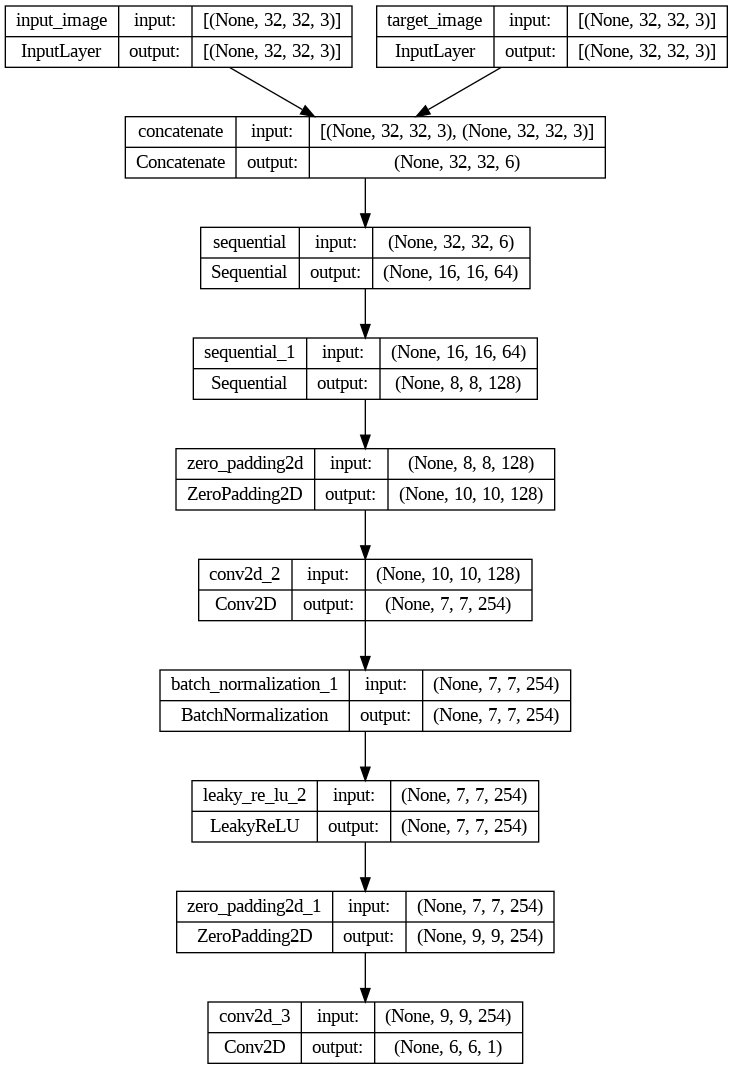

In [6]:
def downsample_block(filters, size, apply_batch_norm = True):
  initializer = tf.random_normal_initializer(0,0.02)

  result = tf.keras.Sequential()

  result.add(
      tf.keras.layers.Conv2D(filters,size,strides = (2,2), padding = "same",kernel_initializer= initializer, use_bias = False)
  )
  if apply_batch_norm:
    result.add(tf.keras.layers.BatchNormalization())
  result.add(tf.keras.layers.LeakyReLU())

  return result

def Discriminator():

  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=(32, 32, 3), name='input_image')
  tar = tf.keras.layers.Input(shape=(32, 32, 3), name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])

  down1 = downsample_block(64, 4, False)(x)
  down2 = downsample_block(128, 4)(down1)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down2)
  conv = tf.keras.layers.Conv2D(254, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)


discriminator = Discriminator()
discriminator.summary()
plot_model(discriminator, to_file='discriminator_model.png', show_shapes=True)

In [7]:
LAMBDA = 100
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  target = tf.cast(target, tf.float32)
  gen_output = tf.cast(gen_output, tf.float32)
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

In [8]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [9]:
@tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    # The generator deblur/denoise the input_image
    generated_images = generator(input_image, training = True)

    # We give the discriminator the clear image and the blurred image and save the classification
    # The discriminator should output that the image is real
    real_output = discriminator([input_image, target], training=True)

    # We do the same but with the claer image and the deblurred image of the generator
    # The discriminator should output that the image is a fake
    fake_output = discriminator([input_image, generated_images], training=True)

    # We calculate the loss for the generator and the discriminator
    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(fake_output, generated_images, target)
    disc_loss = discriminator_loss(real_output, fake_output)
  
  # And then we apply the gradient with the calcualted loss through the optimizer
  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

  train_mse_metric.update_state(target, generated_images)

In [10]:
gen_imgs = []

def generate_images(model, test_input, tar):
  prediction = model(np.reshape(test_input, (1, 32, 32, 3)), training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    im = plt.imshow(display_list[i])
    plt.axis('off')
  
  plt.show()
  gen_imgs.append([prediction[0]])

# Given a train dataset and a test dataset we do 'steps' number of train step
def fit(train_ds, test_ds, steps):
  mses_train = []
  example_input, example_target = next(iter(test_ds.take(1)))
  start = time.time()

  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    # Every 1000 step I print the MSE of the generator and the current result on the same image
    if (step) % 1000 == 0:
      # Update of the mse on training generator
      train_mse = train_mse_metric.result()
      train_mse_metric.reset_states()
      # Save the current mse in a list
      mses_train.append(float(train_mse))

      # Print the update mse, the time taken for the 1000 steps and update of the same image from the generator
      display.clear_output(wait=True)
      print("Training mse over epoch: %.4f" % (float(train_mse),))

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

      start = time.time()

      generate_images(generator, example_input, example_target)
      print(f"Step: {step//1000}k")

    # Main function that does the train step given a blurred image and his orginal image
    train_step(input_image, target, step)

    # Every 10 step write a point, for update visually the status on training
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)

    # Save the checkpoint every 5000 steps
    if (step + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)
  return mses_train

In [11]:
# Creation of the dataset on tensorflow so I can use function like take in the train step
# I took the batch size from the paper I saw this implementation, apparently is really good 1
BATCH_SIZE = 1
BUFFER_SIZE = 400

train_dataset = tf.data.Dataset.from_tensor_slices((masked_x_train, x_train))
# Don't need of this, so I can free the memory in colab
del masked_x_train

test_dataset = tf.data.Dataset.from_tensor_slices((masked_x_test, x_test))
# Don't need of this, so I can free the memory in colab
del x_train

# Shuffle and definition of the batch size
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

test_dataset = test_dataset.batch(BATCH_SIZE)

In [12]:
# My generator is the second model
generator = SecondModel()
discriminator = Discriminator()

# Definition of the mse metric so I can follow the generator mse during the training
train_mse_metric = tf.keras.metrics.MeanSquaredError()

# Definition of the optimizers for the discriminator and the generator 
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Definition of the checkpoint for saving the weights
checkpoint_dir = './content/training_checkpoints'
checkpoint_prefix = checkpoint_dir + "/ckpt"
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

Training mse over epoch: 0.0139


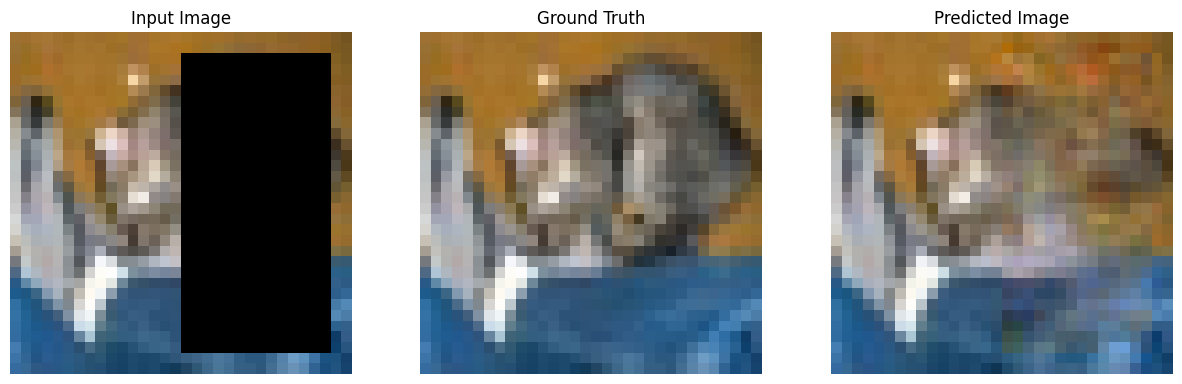

Step: 0k
.............

In [ ]:
%matplotlib inline
import time
import datetime
import pylab as pl

import IPython
from IPython import display

import matplotlib.animation as animation
import matplotlib.pyplot as plt

import absl.logging
from skimage.metrics import structural_similarity as ssim

absl.logging.set_verbosity(absl.logging.ERROR)

third_history = fit(train_dataset, test_dataset, 100000)
third_history = np.delete(third_history, 0)